In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

def process_results_file(file_path, model_name, num_rows=15):
    """
    Process a results file for a given model.
    
    This function extracts device info (CPU, GPU, Memory) from the top of the file
    and processes the file lines to collect metrics for the first 'num_rows' rows
    where "Predictions per frame" equals 1.00.
    
    It returns a dictionary with:
      - model: Model name
      - device_info: Dict with keys "CPU", "GPU", "Memory"
      - rows_considered: Number of rows used (up to num_rows)
      - mean_max_fps, median_max_fps, mean_min_fps, median_min_fps,
        mean_avg_fps, median_avg_fps, mean_pps, median_pps.
      - Raw lists: max_fps_list, min_fps_list, avg_fps_list, pps_list (for later plotting)
    """
    # Initialize device info dictionary
    device_info = {"CPU": None, "GPU": None, "Memory": None}
    
    # Lists for performance metrics
    max_fps_list = []
    min_fps_list = []
    avg_fps_list = []
    pps_list = []
    
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Extract device info (assuming these lines appear near the top)
    for line in lines:
        if "CPU:" in line:
            device_info["CPU"] = line.strip()
        elif "GPU:" in line:
            device_info["GPU"] = line.strip()
        elif "Memory:" in line:
            device_info["Memory"] = line.strip()
    
    # Regex pattern to capture the performance metrics
    pattern = re.compile(
        r"Max FPS:\s*([\d\.]+),\s*Min FPS:\s*([\d\.]+),\s*Avg FPS:\s*([\d\.]+),\s*Predictions per frame:\s*([\d\.]+),\s*PPS:\s*([\d\.]+)"
    )
    
    # Process lines to capture metrics for the first num_rows with Predictions per frame == 1.00
    for line in lines:
        match = pattern.search(line)
        if match:
            max_fps = float(match.group(1))
            min_fps = float(match.group(2))
            avg_fps = float(match.group(3))
            pred_frame = float(match.group(4))
            pps = float(match.group(5))
            
            if pred_frame == 1.00:
                max_fps_list.append(max_fps)
                min_fps_list.append(min_fps)
                avg_fps_list.append(avg_fps)
                pps_list.append(pps)
                
                if len(max_fps_list) == num_rows:
                    break
                    
    if not max_fps_list:
        print(f"No rows with Predictions per frame equal to 1.00 were found in {file_path}")
        return None
    
    # Compute statistics
    result = {
        "model": model_name,
        "device_info": device_info,
        "rows_considered": len(max_fps_list),
        "mean_max_fps": np.mean(max_fps_list),
        "median_max_fps": np.median(max_fps_list),
        "mean_min_fps": np.mean(min_fps_list),
        "median_min_fps": np.median(min_fps_list),
        "mean_avg_fps": np.mean(avg_fps_list),
        "median_avg_fps": np.median(avg_fps_list),
        "mean_pps": np.mean(pps_list),
        "median_pps": np.median(pps_list),
        "max_fps_list": max_fps_list,
        "min_fps_list": min_fps_list,
        "avg_fps_list": avg_fps_list,
        "pps_list": pps_list
    }
    
    # Print out summary for this model
    print(f"Model: {model_name}")
    print("Device Info:")
    for k, v in device_info.items():
        print(f"  {k}: {v}")
    print(f"Rows considered: {result['rows_considered']}")
    print(f"Mean Max FPS: {result['mean_max_fps']:.2f}, Median Max FPS: {result['median_max_fps']:.2f}")
    print(f"Mean Min FPS: {result['mean_min_fps']:.2f}, Median Min FPS: {result['median_min_fps']:.2f}")
    print(f"Mean Avg FPS: {result['mean_avg_fps']:.2f}, Median Avg FPS: {result['median_avg_fps']:.2f}")
    print(f"Mean PPS: {result['mean_pps']:.2f}, Median PPS: {result['median_pps']:.2f}")
    
    # (Optional) Draw diagrams for this model alone:
    # Grouped bar chart for Mean vs. Median for each metric:
    metrics = ["Max FPS", "Min FPS", "Avg FPS", "PPS"]
    mean_values = [result["mean_max_fps"], result["mean_min_fps"], result["mean_avg_fps"], result["mean_pps"]]
    median_values = [result["median_max_fps"], result["median_min_fps"], result["median_avg_fps"], result["median_pps"]]
    
    x = np.arange(len(metrics))
    width = 0.35
    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, mean_values, width, label="Mean", color="skyblue")
    plt.bar(x + width/2, median_values, width, label="Median", color="salmon")
    plt.xticks(x, metrics)
    plt.ylabel("Value")
    plt.title(f"Mean vs. Median for {model_name} (First {num_rows} Rows)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Histograms for each metric (optional):
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    axs = axs.flatten()
    axs[0].hist(result["max_fps_list"], bins=10, color="mediumseagreen", edgecolor="black")
    axs[0].set_title("Max FPS Distribution")
    axs[0].set_xlabel("Max FPS")
    axs[0].set_ylabel("Frequency")
    axs[1].hist(result["min_fps_list"], bins=10, color="mediumpurple", edgecolor="black")
    axs[1].set_title("Min FPS Distribution")
    axs[1].set_xlabel("Min FPS")
    axs[1].set_ylabel("Frequency")
    axs[2].hist(result["avg_fps_list"], bins=10, color="lightcoral", edgecolor="black")
    axs[2].set_title("Avg FPS Distribution")
    axs[2].set_xlabel("Avg FPS")
    axs[2].set_ylabel("Frequency")
    axs[3].hist(result["pps_list"], bins=10, color="darkorange", edgecolor="black")
    axs[3].set_title("PPS Distribution")
    axs[3].set_xlabel("PPS")
    axs[3].set_ylabel("Frequency")
    plt.suptitle(f"Histograms for {model_name} Metrics (First {num_rows} Rows)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return result


In [ ]:
result_mobilenet = process_results_file("AppFPS_Results\\MobileNet (T2)_results.txt", "MobileNet")
result_mobilenet

In [ ]:
result_mobilenetv2 = process_results_file("AppFPS_Results\\MobileNetV2 (T2)_results.txt", "MobileNetV2")
result_mobilenetv2

In [ ]:
result_DenseNet121 = process_results_file("AppFPS_Results\\DenseNet121 (T2)_results.txt", "DenseNet121")
result_DenseNet121

In [ ]:
result_NasNetMobile = process_results_file("AppFPS_Results\\NasNetMobile (T2)_results.txt", "NasNetMobile")
result_NasNetMobile

In [ ]:
result_vgg16 = process_results_file("AppFPS_Results\\VGG16 (T2)_results.txt", "VGG16")
result_vgg16

In [ ]:
result_vgg19 = process_results_file("AppFPS_Results\\VGG19 (T2)_results.txt", "VGG19")
result_vgg19

In [ ]:
result_FusionModel = process_results_file("AppFPS_Results\\Fusion Model (T2)_results.txt", "VGG16+MobileNetV2 Fusion Model")
result_FusionModel

Model: MobileNetV2
Device Info:
  CPU: CPU: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel (28 cores)
  GPU: GPU: NVIDIA GeForce RTX 4070 SUPER
  Memory: Memory: 7.6GB free / 31.8GB total
Rows considered: 15
Mean Max FPS: 15.81, Median Max FPS: 15.87
Mean Min FPS: 10.47, Median Min FPS: 10.15
Mean Avg FPS: 13.63, Median Avg FPS: 13.62
Mean PPS: 14.07, Median PPS: 14.00


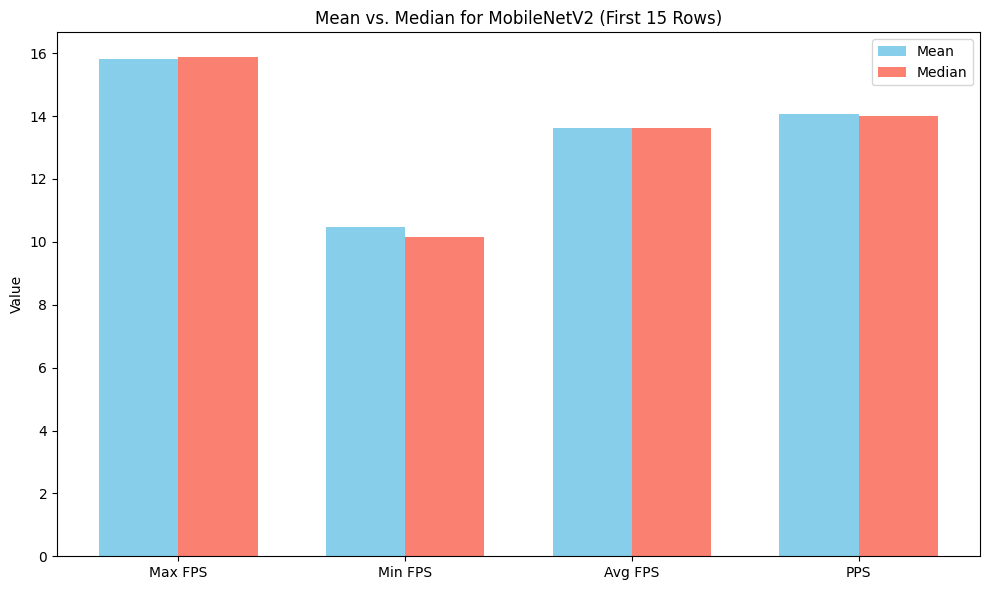

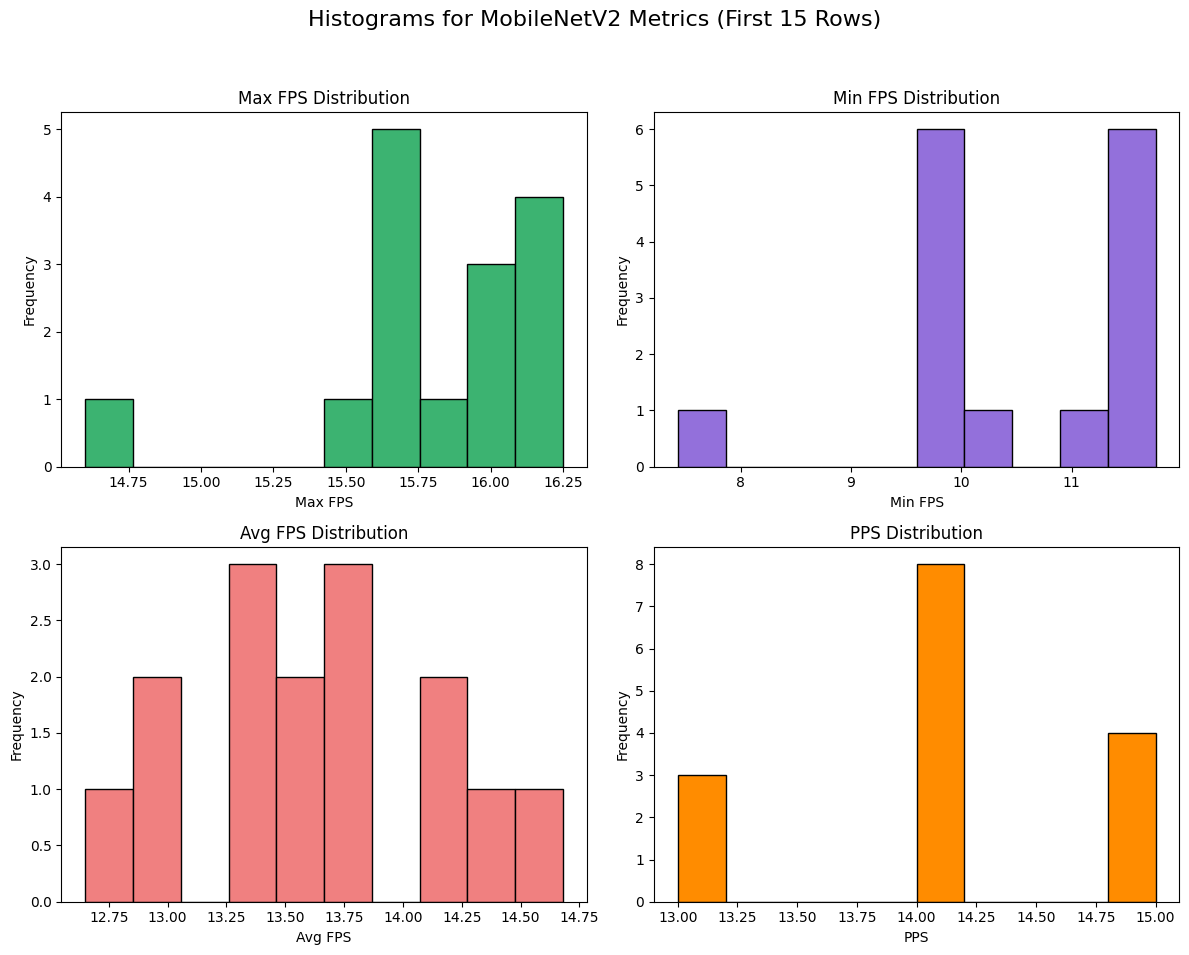

{'model': 'MobileNetV2',
 'device_info': {'CPU': 'CPU: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel (28 cores)',
  'GPU': 'GPU: NVIDIA GeForce RTX 4070 SUPER',
  'Memory': 'Memory: 7.6GB free / 31.8GB total'},
 'rows_considered': 15,
 'mean_max_fps': 15.808666666666666,
 'median_max_fps': 15.87,
 'mean_min_fps': 10.466000000000003,
 'median_min_fps': 10.15,
 'mean_avg_fps': 13.629333333333333,
 'median_avg_fps': 13.62,
 'mean_pps': 14.066666666666666,
 'median_pps': 14.0,
 'max_fps_list': [15.87,
  16.25,
  16.0,
  16.1,
  15.74,
  16.13,
  15.6,
  15.99,
  15.62,
  15.5,
  14.6,
  16.25,
  15.74,
  15.99,
  15.75],
 'min_fps_list': [11.46,
  11.3,
  11.69,
  9.76,
  9.61,
  11.55,
  9.76,
  9.89,
  11.59,
  9.76,
  7.43,
  11.76,
  11.42,
  9.86,
  10.15],
 'avg_fps_list': [13.77,
  14.68,
  14.11,
  13.43,
  13.7,
  14.13,
  13.03,
  13.61,
  13.27,
  13.32,
  12.65,
  14.37,
  13.74,
  13.62,
  13.01],
 'pps_list': [14.0,
  15.0,
  15.0,
  14.0,
  14.0,
  15.0,
  13.0,
  14.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Process results for all models (update file paths as needed)
results = []
results.append(process_results_file("AppFPS_Results\\MobileNetV2_results.txt", "MobileNetV2"))
results.append(process_results_file("AppFPS_Results\\MobileNet_results.txt", "MobileNet"))
results.append(process_results_file("AppFPS_Results\\VGG16_results.txt", "VGG16"))
results.append(process_results_file("AppFPS_Results\\VGG19_results.txt", "VGG19"))
results.append(process_results_file("AppFPS_Results\\NasNetMobile_results.txt", "NasNetMobile"))
results.append(process_results_file("AppFPS_Results\\DenseNet121_results.txt", "DenseNet121"))
results.append(process_results_file("AppFPS_Results\\VGG16_MobileNetV2_Fusion_results.txt", "VGG16+MobileNetV2 Fusion"))

# Remove any None entries if processing failed for any file
results = [r for r in results if r is not None]

# Build a summary table
summary_data = {
    "Model": [r["model"] for r in results],
    "Mean Max FPS": [r["mean_max_fps"] for r in results],
    "Median Max FPS": [r["median_max_fps"] for r in results],
    "Mean Min FPS": [r["mean_min_fps"] for r in results],
    "Median Min FPS": [r["median_min_fps"] for r in results],
    "Mean Avg FPS": [r["mean_avg_fps"] for r in results],
    "Median Avg FPS": [r["median_avg_fps"] for r in results],
    "Mean PPS": [r["mean_pps"] for r in results],
    "Median PPS": [r["median_pps"] for r in results]
}

df_summary = pd.DataFrame(summary_data)
print("Summary of Performance Metrics by Model:")
display(df_summary)

# Determine the most efficient model based on Mean Avg FPS
best_model = df_summary.loc[df_summary["Mean Avg FPS"].idxmax()]
print("\nMost Efficient Model based on Mean Avg FPS:")
display(best_model)

# Compute percentage comparisons relative to the best model for select metrics
for metric in ["Mean Max FPS", "Mean Min FPS", "Mean Avg FPS", "Mean PPS"]:
    best_value = best_model[metric]
    df_summary[f"{metric} (% of best)"] = (df_summary[metric] / best_value) * 100

print("Summary Table with Percentage Comparisons (relative to best model):")
display(df_summary)

# ----- Comparison Plots -----

# Bar chart comparing Mean Avg FPS across models
plt.figure(figsize=(10,6))
plt.bar(df_summary["Model"], df_summary["Mean Avg FPS"], color="skyblue")
plt.ylabel("Mean Avg FPS")
plt.title("Comparison of Mean Avg FPS Across Models")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Grouped bar charts for each metric across models
metrics_to_plot = ["Mean Max FPS", "Mean Min FPS", "Mean Avg FPS", "Mean PPS"]
plt.figure(figsize=(12,8))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2,2,i+1)
    plt.bar(df_summary["Model"], df_summary[metric], color="salmon")
    plt.title(metric)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# Draw a line plot for Mean Avg FPS across models
plt.figure(figsize=(10,6))
plt.plot(df_summary["Model"], df_summary["Mean Avg FPS"], marker="o", color="green")
plt.title("Mean Avg FPS Across Models")
plt.ylabel("Mean Avg FPS")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Draw a line plot for Max, Min and Avg FPS in a model thru the 15 rows (iterating over models)
for i, model in enumerate(results):
    plt.figure(figsize=(10,6))
    plt.plot(results[0]["max_fps_list"], marker="o", label="Max FPS", color="blue")
    plt.plot(results[0]["min_fps_list"], marker="o", label="Min FPS", color="red")
    plt.plot(results[0]["avg_fps_list"], marker="o", label="Avg FPS", color="green")
    plt.title(f"FPS Metrics for {model['model']} (Based on 15 Active Rows)")
    plt.xlabel("Row Number")
    plt.ylabel("FPS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Draw a line plot for PPS in a model thru the 15 rows
for i, model in enumerate(results):
    plt.figure(figsize=(10,6))
    plt.plot(results[0]["pps_list"], marker="o", label="PPS", color="purple")
    plt.title(f"PPS Metrics for {model['model']} (Based on 15 Active Rows)")
    plt.xlabel("Row Number")
    plt.ylabel("PPS")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
